<a href="https://colab.research.google.com/github/jxs203/DRONES/blob/master/John_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Delivery
#### Kaggle competition 


https://www.kaggle.com/c/hashcode-drone-delivery


In [2]:
# All the imports 
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_dist(obj_1, obj_2):
  if not isinstance(obj_1, (list, np.ndarray)):
    c1 = obj_1.coords
  else:
    c1 = obj_1
  if not isinstance(obj_2, (list, np.ndarray)):
    c2 = obj_2.coords
  else:
    c2 = obj_2
  return np.linalg.norm(c1 - c2)

In [4]:
class Simulation():
  """Class containing the simulation definition"""
  def __init__(self, 
               n_rows: int, 
               n_columns:int, 
               D: int, 
               deadline: int, 
               D_max_load: int,
               ) -> None:
    self.n_rows = n_rows
    self.n_columns = n_columns
    self.D = D
    self.deadline = deadline
    self.D_max_load = D_max_load

    self.product_weights = []

    self.warehouses = []
    self.orders = []

    self.step = 0

  @property
  def n_products(self) -> int:
    return len(self.product_weights)

  @property
  def n_warehouses(self) -> int:
    return len(self.warehouses)

  @property
  def n_orders(self) -> int:
    return len(self.orders)

  def __repr__(self)->str:
    out_str  = f"Rows: {self.n_rows}\nColumns: {self.n_columns}\n"
    out_str += f"Drones: {self.D}\nDeadline: {self.deadline}\n"
    out_str += f"Max Load: {self.D_max_load}\nN products: {self.n_products}\n"
    out_str += f"N warehouses: {self.n_warehouses}\nN orders: {self.n_orders}"
    
    return out_str

  def assign_orders(self):
    pass

class Warehouse():
  def __init__(self, coords: list, stock: list, id: int) -> None:
    self.coords = np.array(coords)
    self.stock = stock
    self.id = id

  def __repr__(self) -> None:
    out_str  = f"Warehouse {self.id}\nLocated at:{self.coords}\n"
    out_str += f"Stock:{self.stock}\n"
    return out_str

class CustomerOrder():
  def __init__(self, coords, products, id: int):
    self.coords = np.array(coords, dtype=int)
    self.products = products
    self.id = id

  @property
  def N_items(self)-> int:
    return len(self.products)

  def __repr__(self) -> None:
    out_str  = f"CustomerOrder {self.id}\nLocated at:{self.coords}\n"
    out_str += f"Products:{self.products}\n"
    return out_str


class InputFileParser():
  """
  Loads the datafile d_fn with format as specified in hashcode_delivery_instructions.pdf
  
  Args: 
    d_fn (str): The filepath (absolute or relative) pointing to the data file
  
  Returns: 
    something (): Simulation definition object?
    P_weights (list[int]): Item weights


  Example: 
    parser = InputFileParser()
    # create object
    my_data = parser("path_to_datafile.csv")
    # Call as if it were a function

  """
  def __call__(self, d_fn)-> tuple:
    raw_data = self.load_data_file(d_fn)
    
    data = self.clean_raw_data(raw_data)
    return self.parse_data(data)

  def load_data_file(self, d_fn: str)-> list:
    fn = os.path.abspath(d_fn)
    with open(fn) as _f:
      rawdata = _f.readlines()
    return rawdata

  def clean_raw_data(self, rawdata: list) -> list:
    clean_data = []
    for line in rawdata: 
      line = line.strip()
      line = [int(x) for x in line.split(" ")]
      clean_data.append(line)
    return clean_data

  def parse_data(self, data: list) -> tuple:
    
    simulation_params = Simulation(*data[0])
    simulation_params.product_weights = data[2]

    N_W = data[3][0]
    W_def_end = 4+N_W*2  

    W_data = np.reshape(data[4:W_def_end], [N_W, 2])
    for idx, line in enumerate(W_data):
      simulation_params.warehouses.append(Warehouse(*line, idx))

    N_orders = int(data[W_def_end][0])
    C_data = np.reshape(
        data[W_def_end+1: 1+W_def_end+N_orders*3], #This looks yucky
        [N_orders, 3]
        )
    for idx, C in enumerate(C_data):
      simulation_params.orders.append(CustomerOrder(C[0], C[2], id=idx))

    return simulation_params

In [11]:
parser = InputFileParser()

# May need to replace with your own path? Not sure how collaborative file permissions work 
sim_params = parser("/content/drive/MyDrive/Kaggle_data/busy_day.in")

print(sim_params.orders[0])

CustomerOrder 0
Located at:[340 371]
Products:[226, 183, 6, 220, 299, 280, 12, 42]



In [12]:
def get_axes(sim_params):
    fig, ax  = plt.subplots()

    plt.xlim([0,sim_params.n_rows])
    plt.ylim([0,sim_params.n_columns])
    ax.set_aspect(sim_params.n_rows/sim_params.n_columns)

    return fig, ax

def plot_warehouses(sim_params, 
                    ax=None):

  if ax is None:
    fig, ax = get_axes(sim_params)

  for W in sim_params.warehouses:
    ax.scatter(W.coords[0],W.coords[1], marker="o", c="k")

  return ax


def plot_orders(sim_params, 
                    ax=None):
  if ax is None:
    fig, ax = get_axes(sim_params)

  for O in sim_params.orders:
    ax.scatter(O.coords[0], O.coords[1], marker="x", c="c", alpha=0.3)

  return ax


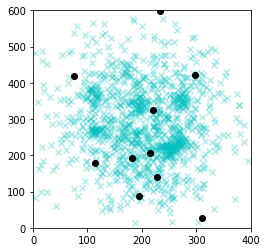

In [13]:
fig, ax = get_axes(sim_params)
plot_orders(sim_params, ax)
plot_warehouses(sim_params, ax)
plt.show()

In [14]:
class TestDataWriter():
  """
  Class to write randomised test data in the correct format
  

  Currently uses the default dist
  """
  def __init__(self, 
               n_rows: int = 1E4, 
               n_columns: int = 1E4, 
               D: int = 1E3, 
               deadline: int = 1E6, 
               D_max_load: int = 1E4,
               warehouses: int = 1E5,
               products: int = 1E5,
               orders: int = 1E5
               ) -> None:

    self.n_rows = np.random.randint(n_rows/2, n_rows)
    self.n_columns = np.random.randint(n_columns/2, n_columns)
    self.D = np.random.randint(D/2, D)
    self.deadline = np.random.randint(deadline/2, deadline)
    self.D_max_load = np.random.randint(D_max_load/2, D_max_load)

    self.product_weights = np.random.randint(1, self.D_max_load, products)

    self.warehouses = []
    self.orders = []

    self.generate_data(warehouses, products, orders)

    self.OUTPUT = []

    self.get_output()

  def rand_coord(self)-> list:

    return " ".join([str(np.random.randint(self.n_rows)), str(np.random.randint(self.n_columns))])

  def generate_data(self, 
                    warehouses: int, 
                    products: int, 
                    orders: int) -> None:

    for W in range(warehouses):
      self.warehouses.append(self.rand_coord()) # coordinate
      self.warehouses.append(
          " ".join([str(a) for a in np.random.randint(1, orders*2, products)])
          ) # Number of products
    
    for O in range(orders):
      self.orders.append(self.rand_coord())
      n_items = np.random.randint(1, products)
      self.orders.append(str(n_items))
      self.orders.append(
          " ".join([str(a) for a in np.random.randint(1,10,n_items)])
          ) # Number of orders

  def get_output(self) -> None:
    
    # various parameters
    self.OUTPUT.append(
        " ".join([str(a) for a in [self.n_rows, self.n_columns, self.D, 
                                   self.deadline, self.D_max_load]])
        )
    
    # product number and weights
    self.OUTPUT.append(str(len(self.product_weights)))
    self.OUTPUT.append(" ".join([str(a) for a in self.product_weights]))

    # warehouses
    self.OUTPUT.append(str(int(len(self.warehouses)/2)))
    self.warehouses = "\n".join(self.warehouses)
    self.OUTPUT.append(self.warehouses)

    # orders
    self.OUTPUT.append(str(int(len(self.orders)/3)))
    self.orders = "\n".join(self.orders)
    self.OUTPUT.append(self.orders)

    # format output for writing
    self.OUTPUT = "\n".join(self.OUTPUT)

  def write(self, filename):

    with open(filename, "w") as fn:
      fn.write(self.OUTPUT)


In [20]:
test = TestDataWriter(
               n_rows = 100, 
               n_columns = 100, 
               D = 10, 
               deadline = 10000, 
               D_max_load = 100,
               warehouses = 14,
               products = 10,
               orders = 50
               )

# print(test.OUTPUT)
test.write("/content/sample_data/test.txt")

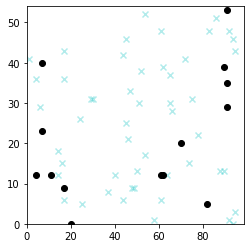

In [21]:
parser = InputFileParser()

# May need to replace with your own path? Not sure how collaborative file permissions work 
sim_params = parser("/content/sample_data/test.txt")

fig, ax = get_axes(sim_params)
plot_orders(sim_params, ax)
plot_warehouses(sim_params, ax)
plt.show()

In [51]:
class DroneOverWeightError(Exception):
  pass

class DroneUnderWeightError(Exception):
  pass

class Drone():

  def __init__(self, 
               coords: list, 
               id: int,
               simulation: Simulation,
               ) -> None:
    self.coords = coords
    self.id = id
    self.simulation = simulation
    
    self.max_weight = self.simulation.D_max_load

    self.busy_until = 0 # if > simulation.step, then drone is not free

    self.inventory = {} # inventory stored as product_id:number_carried
    self.command_history = [] #list of all commands stored

  @property
  def free(self):
    """Used to indicate if the drone is currently free to accept a new command"""
    return self.simulation.step >= self.busy_until  

  def move(self, target) -> None:
    """Method to get the drone to move to a particular coordinate"""
    if not isinstance(target, (list, np.ndarray)):
      target_coords = target.coords
    else:
      target_coords = target
    
    distance = np.ceil(get_dist(self.coords, target_coords))

    self.busy_until = self.simulation.step + distance

    self.coords = target_coords

  def load(self, warehouse: Warehouse, product_id: int, N_items)-> None:
    command_string = f"{self.id} L {warehouse.id} {product_id} {N_items}"
    self.command_history.append(command_string)
    self.move(warehouse.coords)    
    self.busy_until += 1

    if product_id not in self.inventory:
      self.inventory[product_id] = N_items
    else:
      self.inventory[product_id] += N_items
    
    self.check_weight()
         
  def check_weight(self):

    if self.weight > self.max_weight:
      raise DroneOverWeightError(
          f"Drone {self.id} on turn {self.simulation.step} has weight of {self.weight}/{self.max_weight}"
          )
    elif self.weight < 0:
      raise DroneUnderWeightError(
          f"Drone {self.id} on turn {self.simulation.step} has weight of {self.weight}/{self.max_weight}"
          )

  def deliver(self, order: (CustomerOrder, Warehouse), product_id: int, N_items)-> None:
    command_string = f"{self.id} D {order.id} {product_id} {N_items}"
    self.command_history.append(command_string)
    self.move(order.coords)
    self.busy_until += 1
    
    self.inventory[product_id] -= N_items

    self.check_weight()

  def wait(self, turns: int) -> int:
    command_string = f"{self.id} W {turns}"
    self.command_history.append(command_string)
    self.busy_until += self.simulation.turn + turns

  def __repr__(self):
    rep = f"Drone: {self.id}\nLocation: {self.coords}\nInventory: {self.inventory}\n"
    rep += f"Load: {self.weight}/{self.simulation.D_max_load}"
    return rep

  @property
  def weight(self):
    weight = 0
    for p in self.inventory.keys():
      weight += self.inventory[p] * self.simulation.product_weights[p] 
    return weight



In [59]:
print("Initialise drone 0:")
D0 = Drone(coords = np.zeros(2, dtype=int), id = 0, simulation=sim_params)
print(D0)
print("~~~~~~~~~~~")

print("Load drone 0:")
try: 
  D0.load(sim_params.warehouses[5], 0, 5)
except DroneOverWeightError as E:
  print(f"Encountered DroneOverWeightError: {E}")
  print(D0)
  print(D0.weight)
  D0.inventory = {}
print("###")
print("Reverting, and loading less:")
D0.load(sim_params.warehouses[5], 0, 2)
print(D0)
print(D0.weight)
print("~~~~~~~~~~~")

print("Unload drone 0 at a different warehouse:")
try: 
  D0.deliver(sim_params.warehouses[0], 0, 5)
except DroneUnderWeightError as E:
  print(f"Encountered DroneUnderWeightError: {E}")
  print(D0)
  print(D0.weight)
  D0.inventory = {0: 2}
print("###")
print("Reverting, and delivering less:")
D0.deliver(sim_params.warehouses[0], 0, 2)
print(D0)
print(D0.weight)

Initialise drone 0:
Drone: 0
Location: [0 0]
Inventory: {}
Load: 0/62
~~~~~~~~~~~
Load drone 0:
Encountered DroneOverWeightError: Drone 0 on turn 0 has weight of 120/62
Drone: 0
Location: [ 7 23]
Inventory: {0: 5}
Load: 120/62
120
###
Reverting, and loading less:
Drone: 0
Location: [ 7 23]
Inventory: {0: 2}
Load: 48/62
48
~~~~~~~~~~~
Unload drone 0 at a different warehouse:
Encountered DroneUnderWeightError: Drone 0 on turn 0 has weight of -72/62
Drone: 0
Location: [91 35]
Inventory: {0: -3}
Load: -72/62
-72
###
Reverting, and delivering less:
Drone: 0
Location: [91 35]
Inventory: {0: 0}
Load: 0/62
0


In [ ]:
W0 = sim_params.warehouses[0]
W1 = sim_params.warehouses[1]

print(W0.coords - W1.coords)

np.ceil(get_dist(W0, W1))

[ 15 -25]


30.0

In [ ]:
a = np.zeros(3)

print(type(a))
list(a)

isinstance(a, (np.ndarray, list))

<class 'numpy.ndarray'>


True